## Read and Process HTML files ##

In [25]:
import pandas as pd
from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize, word_tokenize
import gensim
from gensim.models import Word2Vec
import logging  # Setting up the loggings to monitor gensim
import re
import unicodedata as ud
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score

d = {ord('\N{COMBINING ACUTE ACCENT}'):None}

# Read html file
def read_file(file_path: str) -> list:
    with open(file_path, 'r') as file:
        html_content = file.read()
    soup = BeautifulSoup(html_content, 'html.parser')
    text = soup.get_text()
    list_words = text.replace('\n', ' ').split(' ')
    return list_words

In [2]:
import os

files = os.listdir('./final_dataset_efeteio')
files = [f for f in files if f.endswith('.html')]

df = pd.DataFrame(columns=['script'])
for f in files:
    list_words = read_file(f'./final_dataset_efeteio/{f}')
    script = ' '.join(list_words)
    df.loc[f] = script    

df.sort_index(inplace=True)
df.head()

,script
1004.html,αριθμος αποφασης αριθμος αποφασης αριθμο...
1006.html,αριθμος αποφασης αριθμος αποφασης εφετει...
1008.html,αριθμος αποφασης αριθμος αποφασης εφετει...
1010.html,αριθμος αποφασης αριθμος αποφασης εφετει...
1012.html,αριθμος αποφασης αριθμος αποφασης εφετει...


In [3]:
df.shape

(3498, 1)

In [4]:
decisions = pd.read_csv('./preprocessed_efeteio/annotated_dataset.csv')    
decisions = decisions[decisions['Decision'].isin(df.index)]
decisions.set_index('Decision', inplace=True)
decisions.sort_index(inplace=True)
decisions.head()

,Label
Decision,
1004.html,1
1006.html,1
1008.html,1
1010.html,1
1012.html,0


In [5]:
decisions

,Label
Decision,
1004.html,1
1006.html,1
1008.html,1
1010.html,1
1012.html,0
...,...
9686.html,0
9688.html,1
969.html,1


In [6]:
decisions.value_counts()

Label
1        3101
0         397
Name: count, dtype: int64

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
import unicodedata

def preprocess_text(file_path):
    with open(file_path, 'r') as file:
        # Read the text from the file
        text = file.read()
        # Convert to lowercase
        text = text.lower()
        # Remove accents
        text = ''.join(char for char in unicodedata.normalize('NFKD', text) if not unicodedata.combining(char))
        # Remove punctuations
        text = re.sub(r'[^\w\s]', '', text)
        # Remove numbers
        text = re.sub(r'\d+', '', text)
        # Remove English characters
        text = re.sub(r'[a-zA-Z]', '', text)
        # Remove all special chars
        text = text.replace('_', '')
        # Transforn to list of words
        text = text.replace('\n', ' ').split(' ')
    return text

# Example usage:
stop_words = preprocess_text('stopwords.txt')

## Creating a balanced dataset to work with ##

In [8]:
df['Label'] = decisions['Label'].values

df_0 = df[df['Label'] == 0]
df_1 = df[df['Label'] == 1]

df_0_sample = df_0.sample(397)
df_1_sample = df_1.sample(700)

df_resampled = pd.concat([df_0_sample, df_1_sample])
df_resampled['Label'].value_counts()

Label
1    700
0    397
Name: count, dtype: int64

In [9]:
df_resampled

,script,Label
8001.html,αριθμος αποφασης αριθμος αποφασης εφετει...,0
1617.html,αριθμος αποφασης αριθμος αποφασης αριθμ...,0
590.html,αριθμος αποφασης αριθμος αποφασης ελληνι...,0
1834.html,αριθμος αποφασης αριθμος αποφασης εφετει...,0
6806.html,αριθμος αποφασης αριθμος αποφασης αριθμο...,0
...,...,...
9188.html,αριθμος αποφασης αριθμος αποφασης τριμελ...,1
4793.html,αριθμος αποφασης αριθμος αποφασης εφετει...,1
7469.html,αριθμος αποφασης αριθμος αποφασης εφετει...,1
6852.html,αριθμος αποφασης αριθμος αποφασης αριθμο...,1


In [10]:
import pandas as pd

# Assuming 'resampled_df' is your resampled dataset (a DataFrame)
memory_usage_bytes = df_resampled.memory_usage(deep=True).sum()

# Convert bytes to megabytes
memory_usage_mb = memory_usage_bytes / (1024 * 1024)

print(f"Estimated memory usage: {memory_usage_mb:.2f} MB")

Estimated memory usage: 65.60 MB


## TF-IDF VECTORIZER ##
TF-IDF Vectorization:

It uses TfidfVectorizer from scikit-learn to convert the text data (df_resampled['script']) into a matrix of TF-IDF features.
The parameters used in TfidfVectorizer are:

norm='l2': This normalizes the vectors to have an L2 norm (unit norm).

stop_words=stop_words: This removes common stop words (as defined by the stop_words variable) from the text before vectorizing.

max_features=5000: Limits the vocabulary to the 5000 most frequent terms.

Transformation:

The fit_transform method is applied to the text data (df_resampled['script']), which learns the vocabulary and IDF (Inverse Document Frequency) values from the data, and then transforms the text data into a TF-IDF weighted term-document matrix.
This matrix is then converted into a dense array using .toarray().

Creating a DataFrame:

The TF-IDF matrix is then converted into a Pandas DataFrame (data_resampled), with the same index as the original DataFrame (df_resampled.index) and with columns named after the terms in the vocabulary (tfidf.get_feature_names_out()).
Appending the Label:

The 'Label' column from the original df_resampled DataFrame is added to the data_resampled DataFrame, aligning by index.





In [11]:
tfidf = TfidfVectorizer(norm='l2', stop_words=stop_words, max_features=500)
tfidf_matrix = tfidf.fit_transform(df_resampled['script']).toarray()

data_resampled = pd.DataFrame(tfidf_matrix, index=df_resampled.index, columns=tfidf.get_feature_names_out())
data_resampled['Label'] = df_resampled['Label'].values

## Classifiers ##

# 1. Random Forest Classifier #

Train shape: (734, 500) | Test shape: (363, 500)


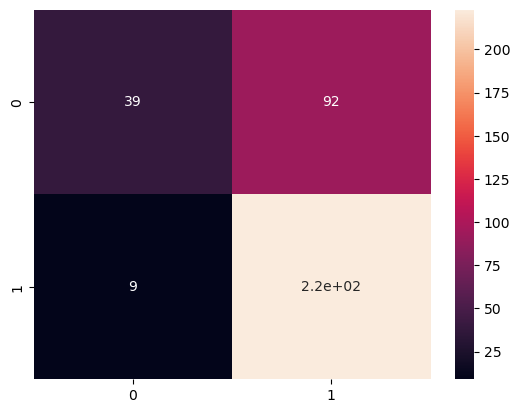

Accuracy: 0.721763085399449
MCC: 0.8153564899451554


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

X = data_resampled.drop('Label', axis=1)
y = data_resampled['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)
print(f'Train shape: {X_train.shape} | Test shape: {X_test.shape}')

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Confusion matrix
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.show()

print(f'Accuracy: {rf.score(X_test, y_test)}')

# Calculate MCC
from sklearn.metrics import matthews_corrcoef, f1_score

mcc = f1_score(y_test, y_pred)
print(f'MCC: {mcc}')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 5/5; 1/50] START bootstrap=False, max_depth=16, max_features=0.7, min_samples_leaf=2, min_samples_split=2, n_estimators=151
[CV 2/5; 1/50] START bootstrap=False, max_depth=16, max_features=0.7, min_samples_leaf=2, min_samples_split=2, n_estimators=151
[CV 3/5; 1/50] START bootstrap=False, max_depth=16, max_features=0.7, min_samples_leaf=2, min_samples_split=2, n_estimators=151
[CV 1/5; 1/50] START bootstrap=False, max_depth=16, max_features=0.7, min_samples_leaf=2, min_samples_split=2, n_estimators=151
[CV 4/5; 1/50] START bootstrap=False, max_depth=16, max_features=0.7, min_samples_leaf=2, min_samples_split=2, n_estimators=151
[CV 1/5; 2/50] START bootstrap=True, max_depth=16, max_features=0.6818181818181818, min_samples_leaf=2, min_samples_split=10, n_estimators=5
[CV 2/5; 2/50] START bootstrap=True, max_depth=16, max_features=0.6818181818181818, min_samples_leaf=2, min_samples_split=10, n_estimators=5
[CV 3/5; 2/50] S

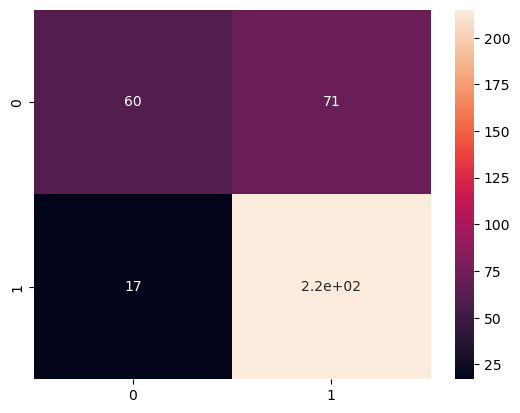

Precision: 0.7517
Recall: 0.9267
Accuracy: 0.7575757575757576
Accuracy: 0.7575757575757576
MCC: 0.4519786600106874
F1: 0.8301158301158301


In [40]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, matthews_corrcoef, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

param_dist = {
    'n_estimators': np.linspace(5, 200, 5, dtype=int),           # Number of trees in the forest
    'max_depth': np.linspace(2, 30, 5, dtype=int),           # Maximum depth of the tree
    'min_samples_split': np.linspace(2, 10, 3, dtype=int),           # Minimum number of samples required to split a node
    'min_samples_leaf': np.linspace(1, 4, 3, dtype=int),             # Minimum number of samples required at a leaf node
    'bootstrap': [True, False],                # Whether bootstrap samples are used when building trees
    'max_features': np.linspace(0.1, 1.0, 100)   # Number of features to consider when looking for the best split
}

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
#                            scoring='matthews_corrcoef',    # You can choose 'accuracy', 'f1', 'roc_auc', etc.
#                            cv=5,            # 5-fold cross-validation
#                            n_jobs=-1,       # Use all available cores
#                            verbose=20)


# Set up RandomizedSearchCV
grid_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=50, cv=5, verbose=20, n_jobs=-1)


# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Access the cross-validation results
cv_results = grid_search.cv_results_

# Number of folds used in cross-validation
num_folds = search.cv

# Initialize a list to store the cumulative scores for each fold
fold_scores = [0] * num_folds

# Sum the test scores for each fold across all parameter sets
for i in range(len(cv_results['params'])):
    for j in range(num_folds):
        fold_scores[j] += cv_results[f'split{j}_test_score'][i]

# Calculate the average score for each fold by dividing by the number of parameter sets
num_params = len(cv_results['params'])
avg_fold_scores = [score / num_params for score in fold_scores]

# Print the average score for each fold
for fold, score in enumerate(avg_fold_scores):
    print(f"Average score for Fold {fold + 1}: {score:.4f}")

# Extract the mean test scores and standard deviation of test scores
mean_test_scores = cv_results['mean_test_score']
std_test_scores = cv_results['std_test_score']

# Print the best score with its standard deviation
best_index = grid_search.best_index_
print(f"Best cross-validation score: {mean_test_scores[best_index]:.4f}")
print(f"Standard deviation of the best score: {std_test_scores[best_index]:.4f}")


# Best estimator (RandomForest with best hyperparameters)
best_rf = grid_search.best_estimator_

# Predict using the best model
y_pred = best_rf.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.show()

# Calculate Precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate Recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Print accuracy of the best model
print(f'Accuracy: {best_rf.score(X_test, y_test)}')

# Calculate F1 score (MCC-like)
f1_score = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {acc}')
print(f'MCC: {mcc}')
print(f'F1: {f1_score}')


## 2. Support Vector Machines ##

Train shape: (734, 500) | Test shape: (363, 500)


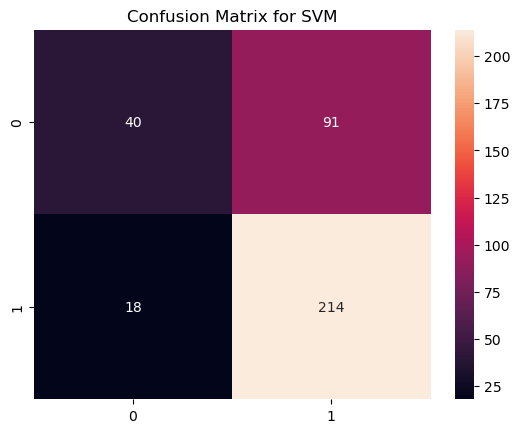

Accuracy: 0.699724517906336
F1 Score: 0.7970204841713222


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC  # Import the SVM classifier
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Split the data into features and labels
X = data_resampled.drop('Label', axis=1)
y = data_resampled['Label']

# Step 2: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)
print(f'Train shape: {X_train.shape} | Test shape: {X_test.shape}')

# Step 3: Initialize and train the SVM classifier
svm = SVC(random_state=42)
svm.fit(X_train, y_train)

# Step 4: Evaluate the SVM classifier
y_pred = svm.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix for SVM')
plt.show()

# Print Accuracy
accuracy = svm.score(X_test, y_test)
print(f'Accuracy: {accuracy}')

# Calculate and print F1 Score (which was previously misnamed as MCC)
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')


Train shape: (734, 500) | Test shape: (363, 500)
Fitting 5 folds for each of 1200 candidates, totalling 6000 fits
[CV] END ...................C=0.01, gamma=0.0, kernel=linear; total time=   0.2s
[CV] END ...................C=0.01, gamma=0.0, kernel=linear; total time=   0.2s
[CV] END ......................C=0.01, gamma=0.0, kernel=rbf; total time=   0.2s
[CV] END ......................C=0.01, gamma=0.0, kernel=rbf; total time=   0.2s
[CV] END ...................C=0.01, gamma=0.0, kernel=linear; total time=   0.2s
[CV] END ...................C=0.01, gamma=0.0, kernel=linear; total time=   0.2s
[CV] END ...................C=0.01, gamma=0.0, kernel=linear; total time=   0.2s
[CV] END ......................C=0.01, gamma=0.0, kernel=rbf; total time=   0.2s
[CV] END ......................C=0.01, gamma=0.0, kernel=rbf; total time=   0.2s
[CV] END ......................C=0.01, gamma=0.0, kernel=rbf; total time=   0.2s
[CV] END ..C=0.01, gamma=0.010101010101010102, kernel=linear; total time=   

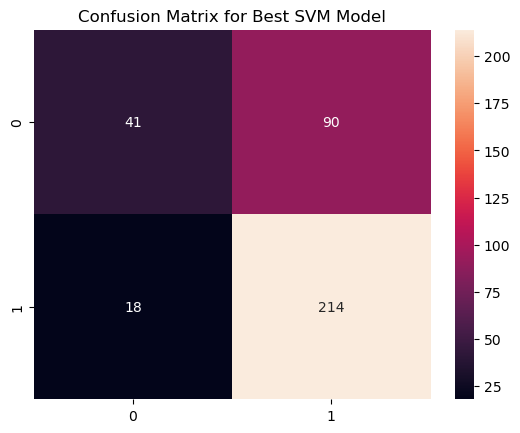

Precision: 0.7039
Recall: 0.9224
Accuracy: 0.7024793388429752
F1 Score: 0.7985074626865671


In [39]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC  # Import the SVM classifier
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Split the data into features and labels
X = data_resampled.drop('Label', axis=1)
y = data_resampled['Label']

# Step 2: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)
print(f'Train shape: {X_train.shape} | Test shape: {X_test.shape}')

# Step 3: Set up the SVM classifier and the parameter grid for GridSearchCV
svm = SVC()

# Define a parameter grid to search for the best parameters
param_grid = {
    'C': [0.01,0.1, 0.5, 1, 10, 100],               # Regularization parameter
    'gamma': np.linspace(0, 1, 100),  # Kernel coefficient
    'kernel': ['linear', 'rbf']            # Kernel types
}
    

# Step 4: Set up GridSearchCV with cross-validation (cv=5)
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='f1', verbose=2, n_jobs=-1)

# Step 5: Fit the model to the training data with GridSearchCV
grid_search.fit(X_train, y_train)

# Access the cross-validation results
cv_results = grid_search.cv_results_

# Number of folds used in cross-validation
num_folds = search.cv

# Initialize a list to store the cumulative scores for each fold
fold_scores = [0] * num_folds

# Sum the test scores for each fold across all parameter sets
for i in range(len(cv_results['params'])):
    for j in range(num_folds):
        fold_scores[j] += cv_results[f'split{j}_test_score'][i]

# Calculate the average score for each fold by dividing by the number of parameter sets
num_params = len(cv_results['params'])
avg_fold_scores = [score / num_params for score in fold_scores]

# Print the average score for each fold
for fold, score in enumerate(avg_fold_scores):
    print(f"Average score for Fold {fold + 1}: {score:.4f}")

# Extract the mean test scores and standard deviation of test scores
mean_test_scores = cv_results['mean_test_score']
std_test_scores = cv_results['std_test_score']

# Print the best score with its standard deviation
best_index = grid_search.best_index_
print(f"Best cross-validation score: {mean_test_scores[best_index]:.4f}")
print(f"Standard deviation of the best score: {std_test_scores[best_index]:.4f}")

# Step 6: Get the best estimator and print the best parameters
best_svm = grid_search.best_estimator_

# Step 7: Use the best model to predict on the test data
y_pred = best_svm.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix for Best SVM Model')
plt.show()

# Calculate Precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate Recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Print Accuracy
accuracy = best_svm.score(X_test, y_test)
print(f'Accuracy: {accuracy}')

# Calculate and print F1 Score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')


## 3. Logistic Regression ## 

Train shape: (509, 100) | Test shape: (251, 100)


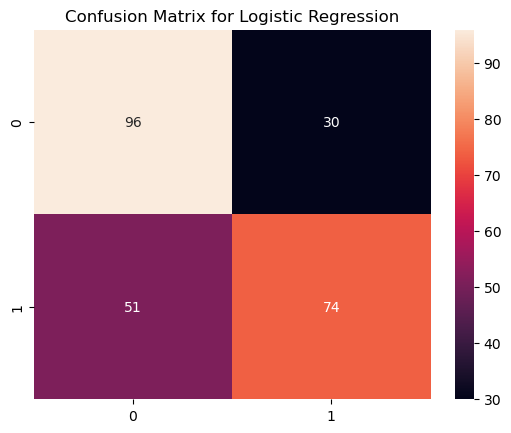

Accuracy: 0.6772908366533864
F1 Score: 0.6462882096069869


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression  # Import Logistic Regression
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Split the data into features and labels
X = data_resampled.drop('Label', axis=1)
y = data_resampled['Label']

# Step 2: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)
print(f'Train shape: {X_train.shape} | Test shape: {X_test.shape}')

# Step 3: Initialize and train the Logistic Regression classifier
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train, y_train)

# Step 4: Evaluate the Logistic Regression classifier
y_pred = lr.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

# Print Accuracy
accuracy = lr.score(X_test, y_test)
print(f'Accuracy: {accuracy}')

# Calculate and print F1 Score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')


In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler



# Step 1: Split the data into features and labels
X = data_resampled.drop('Label', axis=1)
y = data_resampled['Label']

# Step 2: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)
print(f'Train shape: {X_train.shape} | Test shape: {X_test.shape}')

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Set up the Logistic Regression classifier and the parameter grid for GridSearchCV
lr = LogisticRegression(max_iter=2000)

# Define a parameter grid to search for the best parameters
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],        # Inverse of regularization strength
    'penalty': ['l1', 'l2'],  # Regularization types
    'solver': ['saga','liblinear'],                     # Solver for 'elasticnet' regularization
}

# Step 4: Set up GridSearchCV with cross-validation (cv=5)
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='f1', verbose=2, n_jobs=-1)

# Step 5: Fit the model to the training data with GridSearchCV
grid_search.fit(X_train, y_train)

# Access the cross-validation results
cv_results = grid_search.cv_results_

# Number of folds used in cross-validation
num_folds = search.cv

# Initialize a list to store the cumulative scores for each fold
fold_scores = [0] * num_folds

# Sum the test scores for each fold across all parameter sets
for i in range(len(cv_results['params'])):
    for j in range(num_folds):
        fold_scores[j] += cv_results[f'split{j}_test_score'][i]

# Calculate the average score for each fold by dividing by the number of parameter sets
num_params = len(cv_results['params'])
avg_fold_scores = [score / num_params for score in fold_scores]

# Print the average score for each fold
for fold, score in enumerate(avg_fold_scores):
    print(f"Average score for Fold {fold + 1}: {score:.4f}")

# Extract the mean test scores and standard deviation of test scores
mean_test_scores = cv_results['mean_test_score']
std_test_scores = cv_results['std_test_score']

# Print the best score with its standard deviation
best_index = grid_search.best_index_
print(f"Best cross-validation score: {mean_test_scores[best_index]:.4f}")
print(f"Standard deviation of the best score: {std_test_scores[best_index]:.4f}")

# Step 6: Get the best estimator and print the best parameters
best_lr = grid_search.best_estimator_
print(f'Best parameters: {grid_search.best_params_}')


# Step 7: Use the best model to predict on the test data
y_pred = best_lr.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix for Best Logistic Regression Model')
plt.show()

# Calculate Precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate Recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Print Accuracy
accuracy = best_lr.score(X_test, y_test)
print(f'Accuracy: {accuracy}')

# Calculate and print F1 Score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')


NameError: name 'data_resampled' is not defined

# 4. Decision Trees

Train shape: (734, 500) | Test shape: (363, 500)


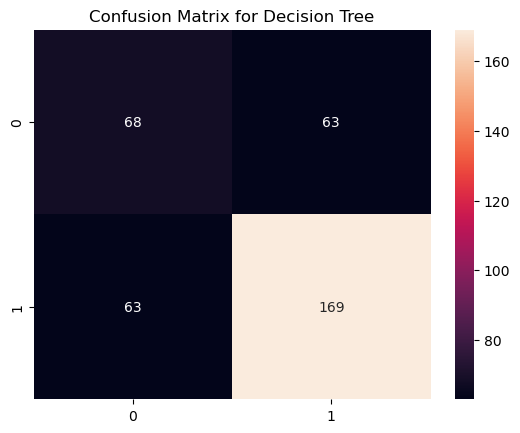

Accuracy: 0.6528925619834711
F1 Score: 0.728448275862069


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier  # Import Decision Tree Classifier
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Split the data into features and labels
X = data_resampled.drop('Label', axis=1)
y = data_resampled['Label']

# Step 2: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)
print(f'Train shape: {X_train.shape} | Test shape: {X_test.shape}')

# Step 3: Initialize and train the Decision Tree classifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Step 4: Evaluate the Decision Tree classifier
y_pred = dt.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix for Decision Tree')
plt.show()

# Print Accuracy
accuracy = dt.score(X_test, y_test)
print(f'Accuracy: {accuracy}')

# Calculate and print F1 Score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Average score for Fold 1: 0.7010
Average score for Fold 2: 0.6940
Average score for Fold 3: 0.7173
Average score for Fold 4: 0.7197
Average score for Fold 5: 0.6838
Best cross-validation score: 0.7258
Standard deviation of the best score: 0.0223
Best parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}


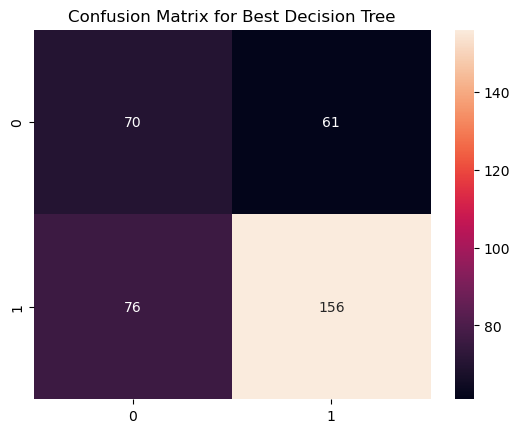

Precision: 0.7189
Recall: 0.6724
Accuracy: 0.6225895316804407
F1 Score: 0.6948775055679287
MCC: 0.20251175683374606


In [37]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Initialize Decision Tree classifier
dt = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=dt, 
                          param_grid=param_grid,
                          cv=5,
                          scoring='f1',
                          n_jobs=-1,
                          verbose=1)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Access the cross-validation results
cv_results = grid_search.cv_results_

# Number of folds used in cross-validation
num_folds = search.cv

# Initialize a list to store the cumulative scores for each fold
fold_scores = [0] * num_folds

# Sum the test scores for each fold across all parameter sets
for i in range(len(cv_results['params'])):
    for j in range(num_folds):
        fold_scores[j] += cv_results[f'split{j}_test_score'][i]

# Calculate the average score for each fold by dividing by the number of parameter sets
num_params = len(cv_results['params'])
avg_fold_scores = [score / num_params for score in fold_scores]

# Print the average score for each fold
for fold, score in enumerate(avg_fold_scores):
    print(f"Average score for Fold {fold + 1}: {score:.4f}")

# Extract the mean test scores and standard deviation of test scores
mean_test_scores = cv_results['mean_test_score']
std_test_scores = cv_results['std_test_score']

# Print the best score with its standard deviation
best_index = grid_search.best_index_
print(f"Best cross-validation score: {mean_test_scores[best_index]:.4f}")
print(f"Standard deviation of the best score: {std_test_scores[best_index]:.4f}")

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)

# Get best model
best_dt = grid_search.best_estimator_

# Make predictions with best model
y_pred = best_dt.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix for Best Decision Tree')
plt.show()

# Calculate Precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate Recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Print Accuracy
accuracy = best_dt.score(X_test, y_test)
print(f'Accuracy: {accuracy}')

# Calculate and print F1 Score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

# Calculate and print Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_test, y_pred)
print(f'MCC: {mcc}')


## 5. XGBoost


Train shape: (734, 500) | Test shape: (363, 500)


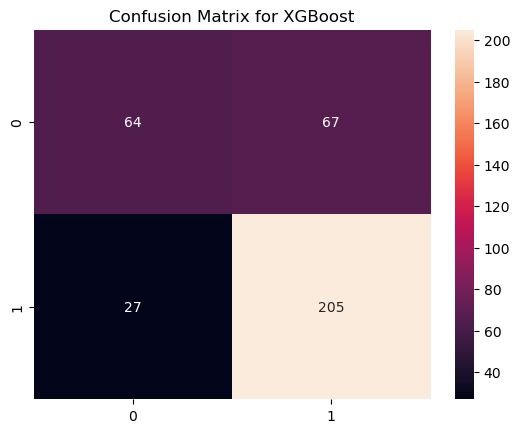

Accuracy: 0.7410468319559229
F1 Score: 0.8134920634920635
MCC: 0.4123976804753255


In [21]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, matthews_corrcoef, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Split the data into features and labels
X = data_resampled.drop('Label', axis=1)
y = data_resampled['Label']

# Step 2: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)
print(f'Train shape: {X_train.shape} | Test shape: {X_test.shape}')

# Step 3: Initialize and train the XGBoost classifier
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

# Step 4: Evaluate the XGBoost classifier
y_pred = xgb.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix for XGBoost')
plt.show()

# Print Accuracy
accuracy = xgb.score(X_test, y_test)
print(f'Accuracy: {accuracy}')

# Calculate and print F1 Score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

# Calculate and print Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_test, y_pred)
print(f'MCC: {mcc}')

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END colsample_bytree=0.5, gamma=0.2, learning_rate=0.16263157894736843, max_depth=9, min_child_weight=3, n_estimators=700, subsample=0.7; total time=   2.5s
[CV] END colsample_bytree=0.5, gamma=0.2, learning_rate=0.16263157894736843, max_depth=9, min_child_weight=3, n_estimators=700, subsample=0.7; total time=   2.5s
[CV] END colsample_bytree=0.5, gamma=0.2, learning_rate=0.16263157894736843, max_depth=9, min_child_weight=3, n_estimators=700, subsample=0.7; total time=   2.5s
[CV] END colsample_bytree=0.5, gamma=0.2, learning_rate=0.16263157894736843, max_depth=9, min_child_weight=3, n_estimators=700, subsample=0.7; total time=   2.6s
[CV] END colsample_bytree=0.5, gamma=0.2, learning_rate=0.16263157894736843, max_depth=9, min_child_weight=3, n_estimators=700, subsample=0.7; total time=   2.6s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.3, max_depth=8, min_child_weight=1, n_estimators=1000, subsample=0.6; 

/Users/thodorismexis/anaconda3/envs/decisions/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END colsample_bytree=0.5, gamma=0.2, learning_rate=0.2236842105263158, max_depth=10, min_child_weight=4, n_estimators=900, subsample=0.9; total time=   3.1s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.3, max_depth=8, min_child_weight=1, n_estimators=1000, subsample=0.6; total time=   3.7s
[CV] END colsample_bytree=1.0, gamma=0.4, learning_rate=0.1473684210526316, max_depth=5, min_child_weight=4, n_estimators=600, subsample=0.9; total time=   2.9s
[CV] END colsample_bytree=1.0, gamma=0.4, learning_rate=0.1473684210526316, max_depth=5, min_child_weight=4, n_estimators=600, subsample=0.9; total time=   2.9s
[CV] END colsample_bytree=1.0, gamma=0.4, learning_rate=0.1473684210526316, max_depth=5, min_child_weight=4, n_estimators=600, subsample=0.9; total time=   2.9s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.3, max_depth=8, min_child_weight=1, n_estimators=1000, subsample=0.6; total time=   3.8s
[CV] END colsample_bytree=1.0, gamma=0.4, learning_rate=0.147

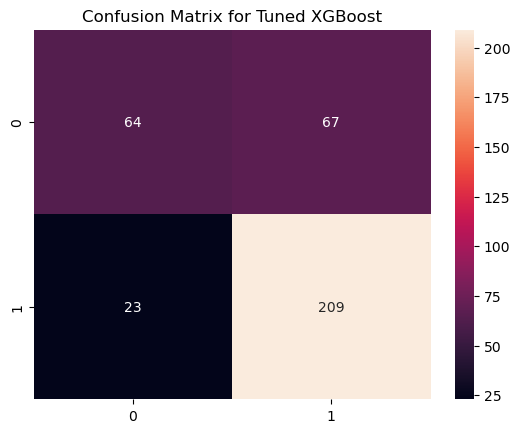

Precision: 0.7572
Recall: 0.9009
Accuracy: 0.7520661157024794
F1 Score: 0.8228346456692913
MCC: 0.43810121200128327


In [36]:
# Define parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': np.linspace(100, 1000, 10, dtype=int),
    'max_depth': np.linspace(3, 10, 8, dtype=int),
    'learning_rate': np.linspace(0.01, 0.3, 20),
    'subsample': np.linspace(0.5, 1.0, 6),
    'colsample_bytree': np.linspace(0.5, 1.0, 6),
    'min_child_weight': [1, 2, 3, 4, 5],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4]
}

# Initialize XGBoost classifier
xgb = XGBClassifier(random_state=42)

# Set GridsearchCV
search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=25,  # Number of parameter settings sampled
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit the model
search.fit(X_train, y_train)

# Access the cross-validation results
cv_results = grid_search.cv_results_

# Number of folds used in cross-validation
num_folds = search.cv

# Initialize a list to store the cumulative scores for each fold
fold_scores = [0] * num_folds

# Sum the test scores for each fold across all parameter sets
for i in range(len(cv_results['params'])):
    for j in range(num_folds):
        fold_scores[j] += cv_results[f'split{j}_test_score'][i]

# Calculate the average score for each fold by dividing by the number of parameter sets
num_params = len(cv_results['params'])
avg_fold_scores = [score / num_params for score in fold_scores]

# Print the average score for each fold
for fold, score in enumerate(avg_fold_scores):
    print(f"Average score for Fold {fold + 1}: {score:.4f}")


# Extract the mean test scores and standard deviation of test scores
mean_test_scores = cv_results['mean_test_score']
std_test_scores = cv_results['std_test_score']

# Print the best score with its standard deviation
best_index = grid_search.best_index_
print(f"Best cross-validation score: {mean_test_scores[best_index]:.4f}")
print(f"Standard deviation of the best score: {std_test_scores[best_index]:.4f}")

# Print best parameters and score
print("Best parameters:", search.best_params_)

# Use best model to predict
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix for Tuned XGBoost')
plt.show()

# Print metrics
accuracy = best_model.score(X_test, y_test)
f1 = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

# Calculate Precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate Recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print(f'MCC: {mcc}')